In [28]:
import numpy as np
import rasterio
from collections import deque
import matplotlib.pyplot as plt

# === Load your rasters ===
with rasterio.open(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\wflow_slope_export.tif") as src: slope = src.read(1)
with rasterio.open(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\wflow_N_land_export.tif") as src: n = src.read(1)
with rasterio.open(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\wflow_uparea_export.tif") as src: acc = src.read(1)
with rasterio.open(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\subcatchments_raster.tif") as src: subcatch = src.read(1)
with rasterio.open(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\wflow_ldd_export.tif") as src:
    ldd = src.read(1)
    transform = src.transform
    cell_size = transform.a  # assumes square pixels

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import os

# === PARAMETERS ===
flow_depth = 0.02  # meters
time_unit = "hours"
factor = {"seconds": 1, "minutes": 60, "hours": 3600}[time_unit]
min_slope = 0.001
min_n = 0.01
num_bins = 500
output_dir = "unit_hydrographs"
os.makedirs(output_dir, exist_ok=True)

# === Flow direction (LDD) codes and offsets ===
ldd_offsets = {
    1: (0, 1), 2: (-1, 1), 3: (-1, 0), 4: (-1, -1),
    5: (0, -1), 6: (1, -1), 7: (1, 0), 8: (1, 1), 9: (0, 0)
}
cell_distance = {
    1: 1.0, 2: np.sqrt(2), 3: 1.0, 4: np.sqrt(2),
    5: 1.0, 6: np.sqrt(2), 7: 1.0, 8: np.sqrt(2), 9: 0.0
}

# === List of subcatchments to process ===
subcatchment_ids = [1, 2, 3, 4, 5, 6, 7, 8, 14, 17]

# === Process each subcatchment ===
for sub_id in subcatchment_ids:
    print(f"\n🔄 Processing subcatchment {sub_id}")
    mask = subcatch == sub_id

    # Validate mask
    if not np.any(mask):
        print(f"⚠️ Subcatchment {sub_id} not found in raster. Skipping.")
        continue

    # Preprocess slope and n
    local_slope = np.where(mask, slope, np.nan)
    local_n = np.where(mask, n, np.nan)
    local_slope[local_slope < min_slope] = min_slope
    local_n[local_n < min_n] = min_n

    # Compute velocity
    velocity = (1 / local_n) * (flow_depth ** (2 / 3)) * np.sqrt(local_slope)
    velocity[~mask] = np.nan

    # Find outlet (max flow accumulation)
    outlet = np.unravel_index(np.nanargmax(np.where(mask, acc, np.nan)), acc.shape)

    # === Compute travel time for each cell in the subcatchment ===
    travel_time = np.full(subcatch.shape, np.nan)
    indices = np.argwhere(mask)
    for row, col in indices:
        if np.isnan(velocity[row, col]):
            continue

        r, c = row, col
        total_dist = 0
        path_valid = True

        while (r, c) != outlet:
            dir_code = ldd[r, c]
            if dir_code not in ldd_offsets or dir_code == 9:
                path_valid = False
                break

            dr, dc = ldd_offsets[dir_code]
            r_new, c_new = r + dr, c + dc

            if not (0 <= r_new < ldd.shape[0] and 0 <= c_new < ldd.shape[1]):
                path_valid = False
                break

            total_dist += cell_size * cell_distance[dir_code]
            r, c = r_new, c_new

        if path_valid and velocity[row, col] > 0:
            travel_time[row, col] = total_dist / velocity[row, col] / factor


    # === Build unit hydrograph ===
    valid_tt = travel_time[~np.isnan(travel_time)]
    if valid_tt.size == 0:
        print(f"⚠️ No valid travel times in subcatchment {sub_id}")
        continue

    hist, bin_edges = np.histogram(valid_tt, bins=num_bins)
    unit_hydrograph = hist / np.sum(hist)

    # === Save to CSV ===
    csv_path = os.path.join(output_dir, f"unit_hydrograph_{sub_id}.csv")
    np.savetxt(csv_path, np.column_stack((bin_edges[:-1], unit_hydrograph)),
               delimiter=",", header="Time,Fraction", comments='')
    print(f"✅ Saved CSV: {csv_path}")

    # === Plot ===
    plt.figure()
    plt.plot(bin_edges[:-1], unit_hydrograph, drawstyle='steps-post')
    plt.xlabel(f"Travel Time ({time_unit})")
    plt.ylabel("Fraction of Runoff")
    plt.title(f"Unit Hydrograph - Subcatchment {sub_id}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"unit_hydrograph_{sub_id}.png"))
    plt.close()
    print(f"📈 Saved plot: unit_hydrograph_{sub_id}.png")

print("\n✅ Done with all subcatchments.")



🔄 Processing subcatchment 1


KeyboardInterrupt: 

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import os
import rasterio
from collections import deque


# === PARAMETERS ===
flow_depth = 0.02  # meters
time_unit = "hours"
factor = {"seconds": 1, "minutes": 60, "hours": 3600}[time_unit]
min_slope = 0.001
min_n = 0.01
num_bins = 500
output_dir = "unit_hydrographs"
os.makedirs(output_dir, exist_ok=True)

# === Flow direction (LDD) codes and offsets ===
ldd_offsets = {
    1: (0, 1), 2: (-1, 1), 3: (-1, 0), 4: (-1, -1),
    5: (0, -1), 6: (1, -1), 7: (1, 0), 8: (1, 1), 9: (0, 0)
}
cell_distance = {
    1: 1.0, 2: np.sqrt(2), 3: 1.0, 4: np.sqrt(2),
    5: 1.0, 6: np.sqrt(2), 7: 1.0, 8: np.sqrt(2), 9: 0.0
}
reverse_ldd = {
    1: 5, 2: 6, 3: 7, 4: 8,
    5: 1, 6: 2, 7: 3, 8: 4
}

# === Load your rasters ===
with rasterio.open(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\wflow_slope_export.tif") as src: slope = src.read(1)
with rasterio.open(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\wflow_N_land_export.tif") as src: n = src.read(1)
with rasterio.open(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\wflow_uparea_export.tif") as src: acc = src.read(1)
with rasterio.open(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\subcatchments_raster.tif") as src: subcatch = src.read(1)
with rasterio.open(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\wflow_ldd_export.tif") as src:
    ldd = src.read(1)
    transform = src.transform
    cell_size = transform.a  # assumes square pixels

# === List of subcatchments to process ===
subcatchment_ids = [1, 2, 3, 4, 5, 6, 7, 8, 14, 17]

# === Process each subcatchment ===
for sub_id in subcatchment_ids:
    print(f"\n🔄 Processing subcatchment {sub_id}")
    mask = subcatch == sub_id

    if not np.any(mask):
        print(f"⚠️ Subcatchment {sub_id} not found. Skipping.")
        continue

    # Preprocess slope and Manning's n
    local_slope = np.where(mask, slope, np.nan)
    local_n = np.where(mask, n, np.nan)
    local_slope[local_slope < min_slope] = min_slope
    local_n[local_n < min_n] = min_n
    velocity = (1 / local_n) * (flow_depth ** (2 / 3)) * np.sqrt(local_slope)
    velocity[~mask] = np.nan

    # Find outlet as the cell with max accumulation
    outlet = np.unravel_index(np.nanargmax(np.where(mask, acc, np.nan)), acc.shape)

    # === Compute travel time using reverse flow (flood-fill style) ===
    travel_time = np.full(subcatch.shape, np.nan)
    visited = np.zeros_like(mask, dtype=bool)
    stack = [outlet]
    travel_time[outlet] = 0
    visited[outlet] = True

    while stack:
        r, c = stack.pop()
        for dir_code, (dr, dc) in ldd_offsets.items():
            rn, cn = r + dr, c + dc
            if not (0 <= rn < ldd.shape[0] and 0 <= cn < ldd.shape[1]):
                continue
            if not mask[rn, cn] or visited[rn, cn]:
                continue
            if ldd[rn, cn] != reverse_ldd[dir_code]:
                continue  # only flow toward (r, c)

            dist = cell_size * cell_distance[dir_code]
            if np.isnan(velocity[rn, cn]) or velocity[rn, cn] <= 0:
                continue

            travel_time[rn, cn] = travel_time[r, c] + dist / velocity[rn, cn] / factor
            visited[rn, cn] = True
            stack.append((rn, cn))

    # === Build and save unit hydrograph ===
    valid_tt = travel_time[~np.isnan(travel_time)]
    if valid_tt.size == 0:
        print(f"⚠️ No valid travel times in subcatchment {sub_id}")
        continue

    hist, bin_edges = np.histogram(valid_tt, bins=num_bins)
    unit_hydrograph = hist / np.sum(hist)

    # Save CSV
    csv_path = os.path.join(output_dir, f"unit_hydrograph_{sub_id}.csv")
    np.savetxt(csv_path, np.column_stack((bin_edges[:-1], unit_hydrograph)),
               delimiter=",", header="Time,Fraction", comments='')
    print(f"✅ Saved CSV: {csv_path}")

    # Save plot
    plt.figure()
    plt.plot(bin_edges[:-1], unit_hydrograph, drawstyle='steps-post')
    plt.xlabel(f"Travel Time ({time_unit})")
    plt.ylabel("Fraction of Runoff")
    plt.title(f"Unit Hydrograph - Subcatchment {sub_id}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"unit_hydrograph_{sub_id}.png"))
    plt.close()
    print(f"📈 Saved plot: unit_hydrograph_{sub_id}.png")

print("\n✅ Done with all subcatchments.")



🔄 Processing subcatchment 1
✅ Saved CSV: unit_hydrographs\unit_hydrograph_1.csv
📈 Saved plot: unit_hydrograph_1.png

🔄 Processing subcatchment 2
✅ Saved CSV: unit_hydrographs\unit_hydrograph_2.csv
📈 Saved plot: unit_hydrograph_2.png

🔄 Processing subcatchment 3
✅ Saved CSV: unit_hydrographs\unit_hydrograph_3.csv
📈 Saved plot: unit_hydrograph_3.png

🔄 Processing subcatchment 4
✅ Saved CSV: unit_hydrographs\unit_hydrograph_4.csv
📈 Saved plot: unit_hydrograph_4.png

🔄 Processing subcatchment 5
✅ Saved CSV: unit_hydrographs\unit_hydrograph_5.csv
📈 Saved plot: unit_hydrograph_5.png

🔄 Processing subcatchment 6
✅ Saved CSV: unit_hydrographs\unit_hydrograph_6.csv
📈 Saved plot: unit_hydrograph_6.png

🔄 Processing subcatchment 7
✅ Saved CSV: unit_hydrographs\unit_hydrograph_7.csv
📈 Saved plot: unit_hydrograph_7.png

🔄 Processing subcatchment 8
✅ Saved CSV: unit_hydrographs\unit_hydrograph_8.csv
📈 Saved plot: unit_hydrograph_8.png

🔄 Processing subcatchment 14
✅ Saved CSV: unit_hydrographs\unit

In [ ]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import mapping, LineString
import pandas as pd
output_dir = r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\results_subcatchments"
# D8 direction mapping
d8_map = {
    1: (0, 1),   2: (-1, 1),  4: (-1, 0),  8: (-1, -1),
    16: (0, -1), 32: (1, -1), 64: (1, 0), 128: (1, 1)
}

# Helper: Trace flow path and store coordinates
def trace_path_coords(r, c, flow_dir, transform):
    path_coords = []
    visited = np.zeros_like(flow_dir, dtype=bool)
    while True:
        if visited[r, c] or flow_dir[r, c] not in d8_map:
            break
        visited[r, c] = True
        x, y = rasterio.transform.xy(transform, r, c)
        path_coords.append((x, y))
        dr, dc = d8_map[flow_dir[r, c]]
        r_next, c_next = r + dr, c + dc
        if not (0 <= r_next < flow_dir.shape[0] and 0 <= c_next < flow_dir.shape[1]):
            break
        r, c = r_next, c_next
    return path_coords

# Load subcatchments and rasters
subcatchments = gpd.read_file(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\Wflow - WitteveenBos\wflow_JMS\HydroMT\Nakuru_res0.002dg_complete_chirps\staticgeoms\subcatch_gauges-new.geojson")
dem_src = rasterio.open(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\wflow_dem.tif")
flow_dir_src = rasterio.open(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\wflow_ldd_export.tif")
fac_src = rasterio.open(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\wflow_uparea_export.tif")
cell_size = dem_src.res[0]

results = []
path_geoms = []

for idx, row in subcatchments.iterrows():
    geom = [mapping(row.geometry)]
    sub_id = row.get("value", idx)

    try:
        dem, transform = mask(dem_src, geom, crop=True)
        fdir, _ = mask(flow_dir_src, geom, crop=True)
        fac, _ = mask(fac_src, geom, crop=True)
    except Exception as e:
        print(f"Skipping subcatchment {sub_id} due to mask error: {e}")
        continue

    fdir = fdir[0].astype(np.uint8)
    fac = fac[0]

    # Track best path
    longest_len = 0
    longest_path_coords = []

    for r in range(fdir.shape[0]):
        for c in range(fdir.shape[1]):
            if fdir[r, c] in d8_map:
                path_coords = trace_path_coords(r, c, fdir, transform)
                length = len(path_coords)
                if length > longest_len:
                    longest_len = length
                    longest_path_coords = path_coords

    length_m = longest_len * cell_size
    print(f"Subcatchment {sub_id}: {length_m:.2f} m")
    results.append({
        "subcatchment_id": sub_id,
        "longest_flow_path_m": length_m
    })
    if longest_path_coords:
        path_geoms.append(LineString(longest_path_coords))

# Save CSV
df = pd.DataFrame(results)

#df.to_csv("longest_flow_paths.csv", index=False)

csv_path = os.path.join(output_dir, f"longest_flow_paths.csv")
np.savetxt(csv_path, df.values, delimiter=",", header="subcatchment_id,longest_flow_path_m", comments='', fmt='%s')
print(f"✅ Saved CSV: {csv_path}")

# Save shapefile
#gdf_paths = gpd.GeoDataFrame(df, geometry=path_geoms, crs=subcatchments.crs)
#gdf_paths.to_file("longest_flow_paths.shp")

#print("Saved longest_flow_paths.csv and longest_flow_paths.shp")


Subcatchment 4.0: 0.02 m
Subcatchment 5.0: 0.01 m
Subcatchment 6.0: 0.02 m
Subcatchment 7.0: 0.02 m
Subcatchment 3.0: 0.04 m
Subcatchment 14.0: 0.01 m
Subcatchment 17.0: 0.01 m
Subcatchment 8.0: 0.02 m
Subcatchment 2.0: 0.04 m
Subcatchment 13.0: 0.04 m
Subcatchment 10.0: 0.11 m
Subcatchment 15.0: 0.06 m
Subcatchment 9.0: 0.05 m
Subcatchment 16.0: 0.02 m
Subcatchment 11.0: 0.03 m
Subcatchment 1.0: 0.05 m
Subcatchment 12.0: 0.06 m


TypeError: savetxt() missing 1 required positional argument: 'X'

In [65]:
import geopandas as gpd
import pandas as pd
import numpy as np
from rasterstats import zonal_stats
from shapely.geometry import mapping

# ---- INPUT FILES ----
subcatchments_fp = r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\Wflow - WitteveenBos\wflow_JMS\HydroMT\Nakuru_res0.002dg_complete_chirps\staticgeoms\subcatch_gauges-new.geojson"
flowpaths_fp = r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\wflow_uparea_export_over_0.2_translated_thinned_clipped_tovect.gpkg"
slope_raster_fp = r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\wflow_slope_export.tif"  # <-- update this

# ---- PARAMETERS ----
rainfall_duration = 3  # hours
output_dir = r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\SCS_unit_hydrographs"
time_step = 0.085  # hours

# ---- FUNCTIONS ----
def compute_lag_time(length_m, slope):
    if slope <= 0:
        slope = 0.001  # avoid division by zero
    Tc = (length_m ** 0.77) / (1900 * (slope ** 0.385)) / 3600  # in hours
    return 0.6 * Tc

def scs_unit_hydrograph(area_km2, Tp_hr, dt=0.085):
    """
    Returns a realistic SCS Unit Hydrograph based on the SCS dimensionless curve.
    area_km2 : watershed area in km²
    Tp_hr : time to peak in hours
    dt : time step in hours
    """
    # Generate time values
    t = np.arange(0, 5 * Tp_hr, dt)  # go far enough to capture tail

    # SCS dimensionless unit hydrograph shape
    Qp = 2.08 * area_km2 / Tp_hr  # peak discharge [m³/s]

    def scs_curve(t_Tp):
        """SCS dimensionless hydrograph shape"""
        if t_Tp < 0:
            return 0
        elif t_Tp <= 1:
            return (t_Tp**2.4)
        else:
            return ((1 / t_Tp) ** 2.4) * np.exp(1.2 * (1 - t_Tp))

    # Evaluate hydrograph
    Q = [Qp * scs_curve(ti / Tp_hr) for ti in t]
    return pd.DataFrame({'Time_hr': t, 'Flow_m3s': Q})


# ---- LOAD DATA ----
catchments = gpd.read_file(subcatchments_fp)
flowpaths = gpd.read_file(flowpaths_fp)

# ---- PROCESS EACH CATCHMENT ----
for idx, catch in catchments.iterrows():
    if idx not in [2, 3, 4, 5, 6, 7, 8, 14, 17]:
        continue

    geom = catch.geometry
    area_km2 = geom.area / 1e6  # assuming projection in meters

    # Intersect flow paths with subcatchment
    sub_flows = flowpaths[flowpaths.intersects(geom)].copy()
    sub_flows["clipped_geom"] = sub_flows.geometry.intersection(geom)
    sub_flows["length_m"] = sub_flows["clipped_geom"].length

    if sub_flows.empty:
        print(f"[!] No flow paths in subcatchment {idx}, skipping.")
        continue

    # Longest flow path
    longest = sub_flows.sort_values("length_m", ascending=False).iloc[0]
    flow_geom = longest["clipped_geom"]

    # Compute average slope from raster
    stats = zonal_stats(
        [mapping(flow_geom)],
        slope_raster_fp,
        stats=["mean"],
        nodata=-9999,
        geojson_out=False
    )
    mean_slope = stats[0]['mean']
    if mean_slope is None:
        print(f"[!] No slope data in subcatchment {idx}, skipping.")
        continue
    print(mean_slope)

    # Compute lag time and unit hydrograph
    L = longest["length_m"]
    TL = compute_lag_time(L, mean_slope)
    Tp = rainfall_duration / 2 + TL

    uh = scs_unit_hydrograph(area_km2, Tp, dt=time_step)

    # Save hydrograph
    out_csv = os.path.join(output_dir, f"unit_hydrograph_catchment_{idx}.csv") 
    uh.to_csv(out_csv, index=False)
    print(f"[✓] Saved: {out_csv}")


C:\Users\jmsch\AppData\Local\Temp\ipykernel_21468\1612138505.py:66: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sub_flows["length_m"] = sub_flows["clipped_geom"].length
C:\Users\jmsch\AppData\Local\Temp\ipykernel_21468\1612138505.py:66: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sub_flows["length_m"] = sub_flows["clipped_geom"].length
C:\Users\jmsch\AppData\Local\Temp\ipykernel_21468\1612138505.py:66: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sub_flows["length_m"] = sub_flows["clipped_geom"].length
C:\Users\jmsch\AppData\Local\Temp\ipykernel_21468\1612138505.py:66: Us

0.08061736159854466
[✓] Saved: C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\SCS_unit_hydrographs\unit_hydrograph_catchment_2.csv
0.1260440468788147
[✓] Saved: C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\SCS_unit_hydrographs\unit_hydrograph_catchment_3.csv
0.038165910376442805
[✓] Saved: C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\SCS_unit_hydrographs\unit_hydrograph_catchment_4.csv
0.03324415783087412
[✓] Saved: C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\SCS_unit_hydrographs\unit_hydrograph_catchment_5.csv
0.023991474881768227
[✓] Saved: C:\Users

C:\Users\jmsch\AppData\Local\Temp\ipykernel_21468\1612138505.py:66: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sub_flows["length_m"] = sub_flows["clipped_geom"].length
C:\Users\jmsch\AppData\Local\Temp\ipykernel_21468\1612138505.py:66: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sub_flows["length_m"] = sub_flows["clipped_geom"].length


In [63]:
display(uh)

,Time_hr,Flow_m3s
0,0.000,0.000000e+00
1,0.085,3.621229e-12
2,0.170,1.911296e-11
3,0.255,5.057630e-11
4,0.340,1.008788e-10
...,...,...
84,7.140,9.227336e-13
85,7.225,8.379328e-13
86,7.310,7.611781e-13
87,7.395,6.916786e-13


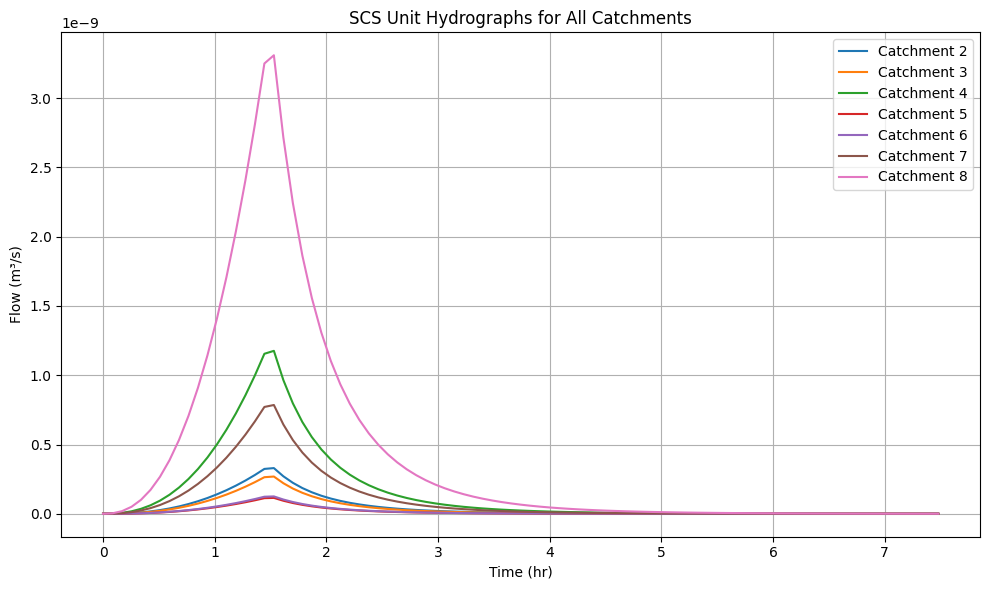

In [64]:
import matplotlib.pyplot as plt
import os
import pandas as pd

# Directory where hydrograph CSVs are saved
output_dir = r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\Flowpathlength\SCS_unit_hydrographs"

# List all CSVs for unit hydrographs
csv_files = [f for f in os.listdir(output_dir) if f.startswith("unit_hydrograph_catchment_") and f.endswith(".csv")]

plt.figure(figsize=(10, 6))

for csv in csv_files:
    df = pd.read_csv(os.path.join(output_dir, csv))
    catchment_id = csv.split("_")[-1].replace(".csv", "")
    plt.plot(df["Time_hr"], df["Flow_m3s"], label=f"Catchment {catchment_id}")

plt.xlabel("Time (hr)")
plt.ylabel("Flow (m³/s)")
plt.title("SCS Unit Hydrographs for All Catchments")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()